### General Pipeline for Pitch Predictor

In [2]:
# %pip install pybaseball
# %pip install polars
# %pip install scikit-learn
# %pip install pca

In [3]:
import polars as pl
import pybaseball as pb
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import polars.selectors as cs
import pca
import feature_cols as fc

### Get Pitcher Information

In [4]:
pb.cache.enable()

# Insert Pitcher Name of interest here
(pitcher_info := pb.playerid_lookup('Arrieta', 'Jake')
)

(player_id := pitcher_info['key_mlbam'][0])

(start_year := int(pitcher_info['mlb_played_first'][0]))

(end_year := int(pitcher_info['mlb_played_last'][0]))
# Scraping Data using pybaseball from baseballsavant.com
years = range(start_year, end_year + 1)

dfs = []
for y in years:
    print(f"Fetching {y} data...")
    try:
        df_year = pb.statcast_pitcher(f"{y}-01-01", f"{y}-12-31", player_id)
        if not df_year.empty:
            dfs.append(pl.from_pandas(df_year))
    except Exception as e:
        print(f"No data for {y}: {e}")
if dfs:
    all_pitches = pl.concat(dfs, how="vertical_relaxed")
    print(f"\nCombined dataset shape: {all_pitches.shape}")
    print("Columns:", all_pitches.columns)
else:
    print("No data found for this player.")

Fetching 2010 data...
Gathering Player Data
Fetching 2011 data...
Gathering Player Data
Fetching 2012 data...
Gathering Player Data
Fetching 2013 data...
Gathering Player Data
Fetching 2014 data...
Gathering Player Data
Fetching 2015 data...
Gathering Player Data
Fetching 2016 data...
Gathering Player Data
Fetching 2017 data...
Gathering Player Data
Fetching 2018 data...
Gathering Player Data
Fetching 2019 data...
Gathering Player Data
Fetching 2020 data...
Gathering Player Data
Fetching 2021 data...
Gathering Player Data

Combined dataset shape: (28306, 118)
Columns: ['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_

### Cleaning

In [5]:
(clean_pitches := all_pitches.select(fc.feature_cols).drop_nulls())

pitch_type,release_speed,release_pos_x,release_pos_z,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,effective_speed,release_spin_rate,release_extension,release_pos_y,spin_axis,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""FF""",93.2,-3.35,6.56,-0.68,1.53,0.77,1.11,12.24707,-135.613117,-11.013413,-10.516,26.108,-11.643,3.3,1.55,93.9,2295.0,6.5,54.5,206.0,1.14,0.68,-0.68
"""SL""",87.3,-3.33,6.45,0.75,0.6,0.07,2.13,6.376441,-127.554027,-4.647818,6.997,20.69,-24.934,3.3,1.55,88.0,2462.0,6.1,54.5,150.0,2.39,-0.75,0.75
"""CU""",80.9,-3.07,6.59,1.3,-1.02,1.62,-0.58,7.554049,-118.275298,-5.698111,10.077,24.981,-40.127,3.3,1.55,79.9,2991.0,5.8,54.5,37.0,4.61,-1.3,1.3
"""FF""",92.3,-3.14,6.6,-0.97,1.26,-1.6,3.93,6.389359,-135.17937,-3.122889,-12.884,27.494,-16.529,3.3,1.55,93.6,2283.0,6.7,54.5,221.0,1.44,0.97,-0.97
"""SI""",91.4,-3.18,6.59,-0.99,1.07,-0.66,2.62,8.849001,-133.651316,-5.716023,-13.378,27.446,-18.616,3.3,1.55,92.2,2227.0,6.5,54.5,233.0,1.7,0.99,-0.99
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SI""",91.8,-2.71,6.17,-1.53,0.58,-0.62,1.38,8.508889,-133.373562,-7.515773,-19.983888,24.958074,-23.935361,3.47,1.7,91.5,2263.0,5.9,54.6,229.0,2.11,1.53,-1.53
"""SL""",90.1,-2.73,6.15,0.12,0.73,1.55,1.03,10.305534,-130.826544,-8.393499,-0.275587,20.982121,-22.323487,3.52,1.72,90.4,2511.0,6.0,54.45,193.0,2.03,-0.12,0.12
"""CU""",81.3,-2.75,6.23,1.05,-1.05,0.47,0.8,5.154,-118.27801,-3.524704,8.874566,22.595469,-41.547956,3.55,1.78,80.6,2788.0,5.9,54.64,38.0,4.5,-1.05,1.05


In [6]:
clean_pitches.write_csv("./data/arrieta_full.csv")

### PCA

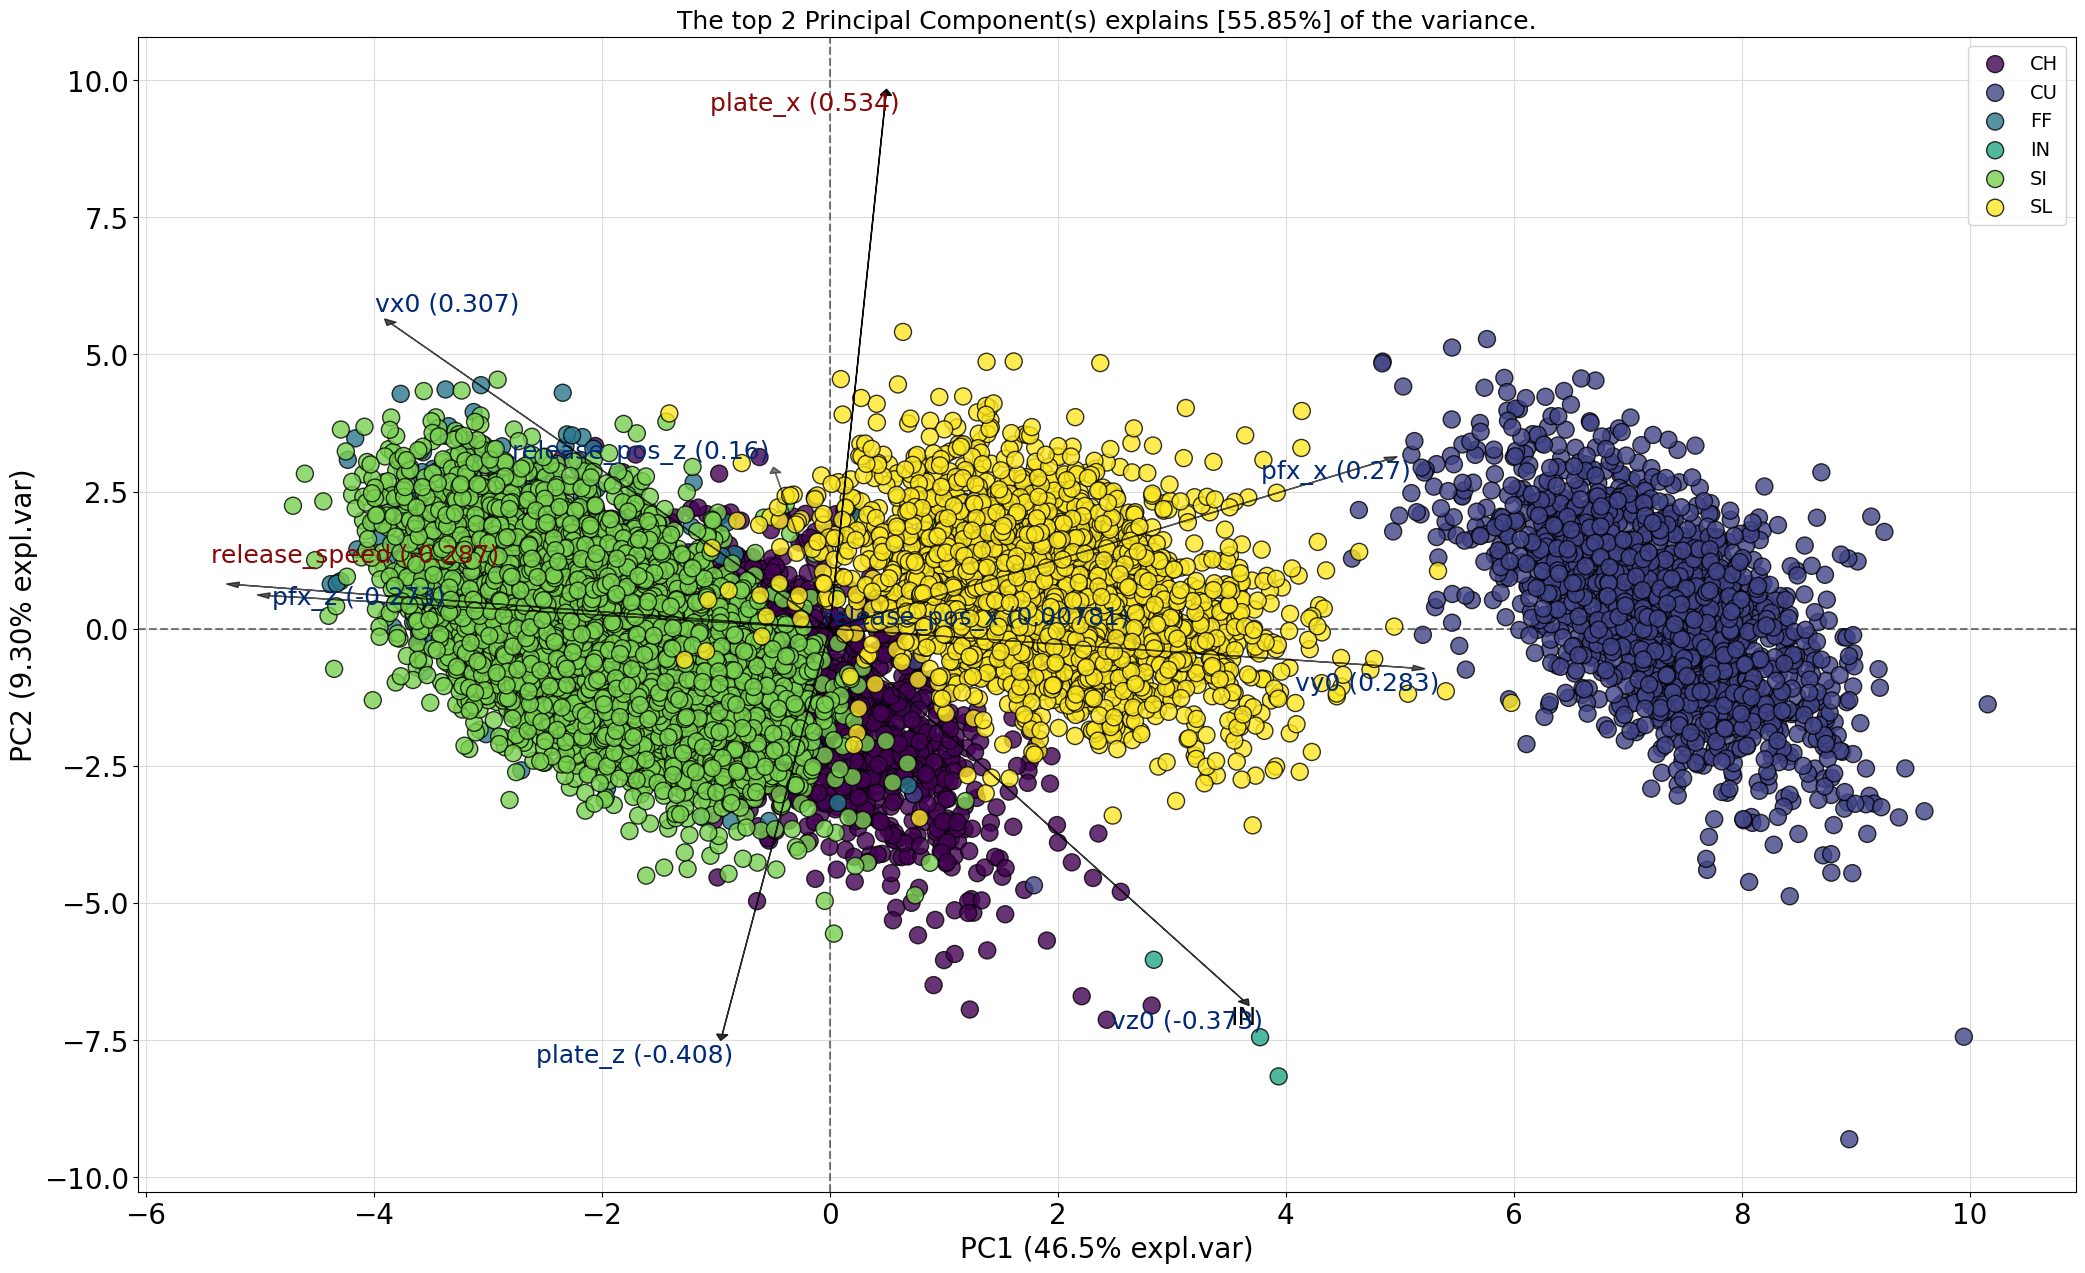

In [7]:
# 1. Prepare Data
data = all_pitches.drop_nulls(subset=fc.feature_cols + ['pitch_type'])
X = data.select(fc.feature_cols).select(cs.numeric())

# 2. Run PCA (Normalized)
model = pca.pca(n_components=2, normalize=True, verbose=0)
model.fit_transform(X.to_pandas(), col_labels=X.columns, row_labels=data['pitch_type'].to_list())

# 3. Orient: Flip PC1 to match R
model.results['PC']['PC1'] *= -1
model.results['loadings'].loc['PC1'] *= -1

# 4. Biplot: Black arrows ('k') and text
fig, ax = model.biplot(n_feat=10, legend=True, label=False, cmap='viridis',
                       color_arrow='k')

# Add crosshairs & labels
ax.axhline(0, color='black', ls='--', lw=1.5, alpha=0.5)
ax.axvline(0, color='black', ls='--', lw=1.5, alpha=0.5)

### KMeans Clustering

### CART and Random Forest